<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1> Overcomplete Autoencoders for Denoising  </h1>

<h2>Table of Contents</h2>
<p>In this lab, you will see how Overcomplete Autoencoders  can be used for Denoising. </p>

<ul>
    <li><a href="#AF">auxiliary function and Imports</a></li>
    <li><a href="#LD">Load Data</a></li>
    <li><a href="#CA">Compare Autoencoders </a></li>
</ul>
<p>Estimated Time Needed: <strong>20 min</strong></p>

<hr>

<h2 id="AF">Auxiliary Function and Imports </h2>

We'll need the following libraries

In [2]:
# Import the libraries we need for the lab

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(0);

Create a dataset object where noise <code>x_</code> will be the noisy sample, and <code>x</code> will be the correct input.

In [3]:
# Create Data object

class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES=400, noise_std=0.1, train=True):
        self.x=torch.zeros(( N_SAMPLES,2))
        
        self.x_=torch.zeros(( N_SAMPLES,2))
        
        self.x[:,0] = torch.linspace(0, 2, N_SAMPLES)
        self.x[self.x[:,0]<1,1]=1
        self.x[:,1]=self.x[:,1]+1
        self.len=N_SAMPLES
        if train != True:
            torch.manual_seed(1)
            self.x_[:,0] = self.x[:,0]+ noise_std * torch.randn(N_SAMPLES)
            self.x_[:,1] = self.x[:,1]+ noise_std * torch.randn(N_SAMPLES)
            
        else:
            torch.manual_seed(0)
            self.x_[:,0] = self.x[:,0]+ noise_std * torch.randn(N_SAMPLES)
            self.x_[:,1] = self.x[:,1]+ noise_std * torch.randn(N_SAMPLES)
    
    # Getter
    def __getitem__(self, index):    
        return self.x_[index,:], self.x[index,:]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the data
    def plot(self):
        plt.figure(figsize = (6.1, 10))
        plt.scatter(self.x_[:,0].numpy(),self.x_[:,1].numpy(), label="Noisy function")
        plt.plot(self.x[:,0].numpy(), self.x[:,1].numpy() ,label="True function", color='orange')
        plt.xlabel("x_{1}")
        plt.ylabel("x_{2}")
        plt.xlim((0, 2))
        #plt.ylim((0, 2.5))
        plt.legend(loc="best")
        plt.tight_layout()
        plt.show()

This function will plot the data points before and after they are passed through the autoencoder. 

In [4]:
def plot_points(model,dataset):

    xhat_points=model(dataset.x_)
    f_xat=model(dataset.x)

    plt.scatter(dataset.x_[:,0].numpy(),dataset.x_[:,1].numpy(), label="x_")
    plt.plot(dataset.x[:,0].numpy(), dataset.x[:,1].numpy(),'g' ,label="f",)
    plt.plot(f_xat[:,0].detach().numpy(), f_xat[:,1].detach().numpy() ,label="fhat", color='r')
    plt.scatter(xhat_points[:,0].detach().numpy(),xhat_points[:,1].detach().numpy(), label="xhat")    
    
    plt.legend() 
    plt.show()  

<h2 id="LD">Load Data </h2>

Create a dataset object:

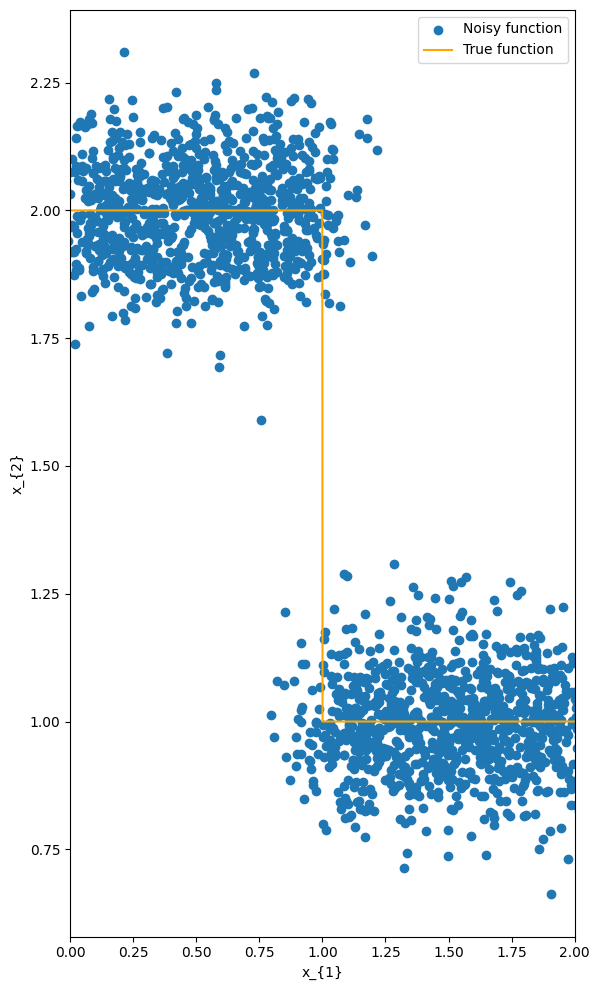

In [5]:
# Create the dataset object and plot the dataset
train_dataset = Data(N_SAMPLES=2000, noise_std=0.1)
train_dataset.plot()

Get some validation data: 

In [6]:
# Create validation dataset object
validation_dataset = Data(N_SAMPLES=400, noise_std=0.1,train=False)
len(train_dataset)

2000

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset , batch_size=2)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=2)

<h2 id="Model_Cost">Create the Model, Optimizer, and Total Loss Function (Cost)</h2>

Create a custom module with three layers. <code>in_size</code> is the size of the input features, <code>n_hidden</code> is the size of the layers, and <code>out_size</code> is the size. <code>p</code> is dropout probability. The default is 0 which is no dropout.

In [8]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4):   
    #global variable 
    cost_list_training =[]
    cost_list_validation =[]
    for epoch in range(n_epochs):
        cost_training=0
        for x_tilde, x in train_loader:
            
            model.train()
            optimizer.zero_grad()
            xhat = model(x_tilde)
            loss = criterion(xhat, x)
            loss.backward()
            optimizer.step()
            cost_training+=loss.data
        
        cost_list_training.append(cost_training)
    
        #perform a prediction on the validation  data  
        cost_val=0
        for x_tilde, x in validation_loader:
            
            model.eval()
            xhat = model(x_tilde)
            loss = criterion(xhat, x)
            cost_val+=loss.data
            
        cost_list_validation.append(cost_val)
    
    return cost_list_training, cost_list_validation

Function to plot training cost and validation cost.

In [9]:
def plot_train_val(cost_list,accuracy_list,val_data_label ='accuracy'):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(cost_list, color = color)
    ax1.set_xlabel('epoch ', color = color)
    ax1.set_ylabel('total cost', color = color)
    ax1.tick_params(axis = 'y', color = color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(val_data_label, color = color)  # we already handled the x-label with ax1
    ax2.plot(accuracy_list, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()
    plt.show()

<h2 id="CA">Compare Autoencoders</h2>

Create a linear autoencoder custom module and an autoencoder custom module  with a Rulu function encoder and Selu decoder function.

In [10]:
class AutoEncoder(nn.Module):
    
    # Contructor
    def __init__(self, input_dim=2, encoding_dim=2):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Linear(input_dim,encoding_dim)
        self.decoder = nn.Linear(encoding_dim,input_dim)
    
    # Prediction
    def forward(self, x):
        x =  self.encoder(x)
        x=self.decoder(x)
        return x
    
    def code(self,x):
        return self.encoder(x)

In [11]:
 class AutoEncoder_non_lin(nn.Module):   
    def __init__(self, input_dim=2, encoding_dim=2):
        super(AutoEncoder_non_lin, self).__init__()
        
        self.encoder = nn.Linear(input_dim,encoding_dim)
        self.decoder = nn.Linear(encoding_dim,input_dim)
    
    # Prediction
    def forward(self, x):
        x =  torch.relu(self.encoder(x))
        x=torch.selu(self.decoder(x))
        
        return x
    
    def code(self,x):
        return self.encoder(x)

The following is an example of a linear undercomplete autoencoder.

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/DL0110EN/Version_3/Chapter_10/images/under_complete%20.png" width="400" alt="cognitiveclass.ai logo" />

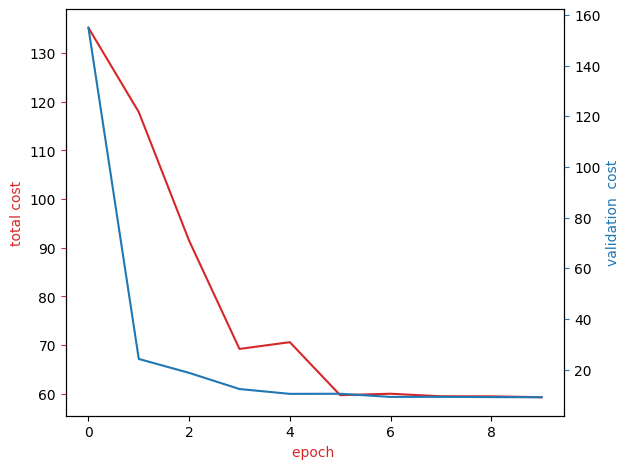

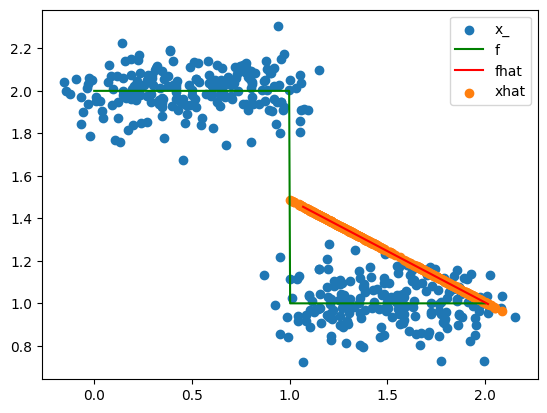

validation  cost tensor(59.2714)
training cost tensor(9.0595)


In [12]:
model_linear=AutoEncoder(2,1)
criterion = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model_linear.parameters(), lr = learning_rate)
train_cost,validation_cost = train_model(
    model=model_linear,n_epochs=10,train_loader=train_loader,
    validation_loader=validation_loader,optimizer=optimizer
)
plot_train_val(validation_cost, train_cost,val_data_label ='validation  cost')

plot_points(model_linear,validation_dataset)
print("validation  cost",validation_cost[-1] )
print("training cost",train_cost[-1] )

The following is an example of a linear overcomplete autoencoder:

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/DL0110EN/Version_3/Chapter_10/images/over_complete%20.png" width="400" alt="cognitiveclass.ai logo" />

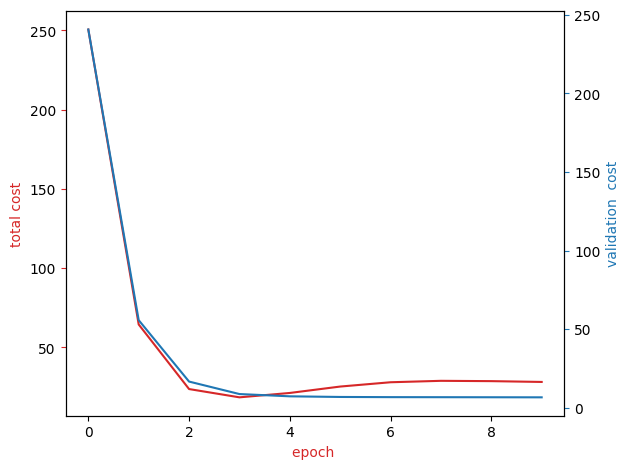

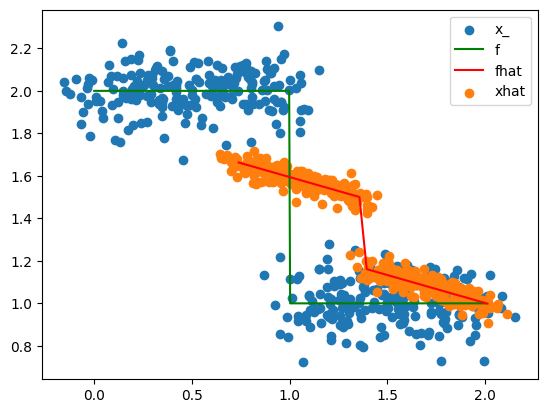

validation  cost tensor(28.2520)
training cost tensor(6.6601)


In [13]:
model_linear=AutoEncoder(2,10)
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model_linear.parameters(), lr = learning_rate)
train_cost,validation_cost = train_model(
    model=model_linear,n_epochs=10,train_loader=train_loader,
    validation_loader=validation_loader,optimizer=optimizer
)
plot_train_val(validation_cost, train_cost,val_data_label ='validation  cost')

plot_points(model_linear,validation_dataset)
print("validation  cost",validation_cost[-1] )
print("training cost",train_cost[-1] )

The following is an example of an overcomplete autoencoder with a  Rulu function encoder and Selu decoder function.This will take more (and hence, much more time) iteration to converge.

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/DL0110EN/Version_3/Chapter_10/images/non_linear%20.png" width="400" alt="cognitiveclass.ai logo" />

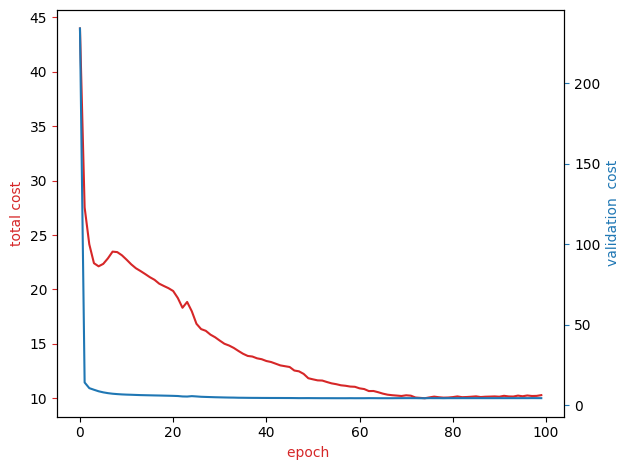

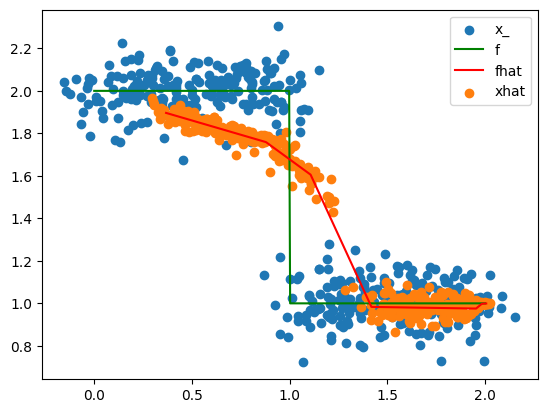

validation  cost tensor(10.2930)
training cost tensor(4.3669)


In [14]:
model_non_linear=AutoEncoder_non_lin(2,10)
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model_non_linear.parameters(), lr = learning_rate)
train_cost,validation_cost=train_model(model=model_non_linear,n_epochs=100,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)
plot_train_val(validation_cost, train_cost,val_data_label ='validation  cost')
plot_points(model_non_linear,validation_dataset)
print("validation  cost",validation_cost[-1] )
print("training cost",train_cost[-1] )


We see the nonlinear autoencoder performs best.

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 

<hr>

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.